In [113]:
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope
import pandas as pd
import plotly.express as px
from sktime.forecasting.compose import DirectTabularRegressionForecaster,DirectTimeSeriesRegressionForecaster, RecursiveTabularRegressionForecaster, TransformedTargetForecaster, ForecastingPipeline
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.date import DateTimeFeatures

from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.datasets import load_arrow_head, load_basic_motions
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender,ConditionalDeseasonalizer, Deseasonalizer
from collections import defaultdict
import itertools
from prophet import Prophet
import plotly.graph_objects as go
from scipy.stats import norm

In [3]:
df = pd.read_parquet('stat_product_ibe3_breakdown_daily_grouped_pos_productstatus_2021.parquet')

In [4]:
df

,trx_day,product_status,pos,product_count,price
3752,2021-01-01,COMPLETED,IBE,2809,24728228.00
5172,2021-01-01,HISTORIC,MYB-iph,13,149358.00
2843,2021-01-01,HISTORIC,CCM-manual,9,46469.00
6860,2021-01-01,COMPLETED,IPH,2502,18931380.00
14815,2021-01-01,BOOKED,ANDROID,1,15621.00
...,...,...,...,...,...
3359,2021-10-31,INITIAL,CCM-manual,12,0.00
12832,2021-10-31,HISTORIC,None,73,526739.50
3259,2021-10-31,COMPLETED,MYB-iph,325,3012882.77
15617,2021-10-31,CANCELLED,MYB,13,231592.00


In [46]:
TIME_COL = 'trx_day'
TARGET_COL = 'product_count'

df_pc = pd.DataFrame(df.groupby(['trx_day', 'product_status'])['product_count'].agg(sum)).reset_index()
dum = pd.get_dummies(df_pc[['product_status']], columns=['product_status']).multiply(df_pc[TARGET_COL], axis='index')
columns = [TARGET_COL] + list(dum.columns)
d = pd.concat([df_pc[['trx_day','product_count']], dum], axis='columns')
df_pc = d.groupby(TIME_COL)[columns].agg(sum)

In [56]:
df_pc

,product_count,product_status_BOOKED,product_status_CANCELLED,product_status_COMPLETED,product_status_HISTORIC,product_status_INITIAL
trx_day,,,,,,
2021-01-01,20952,157,3206,15786,1375,428
2021-01-02,26095,202,3799,19895,1800,399
2021-01-03,24328,158,3341,18917,1637,275
2021-01-04,23970,199,3263,18637,1580,291
2021-01-05,24056,172,3232,18829,1515,308
...,...,...,...,...,...,...
2021-10-27,36974,472,4613,28725,1029,2135
2021-10-28,30914,501,4615,24983,680,135
2021-10-29,31709,505,4899,24960,1221,124


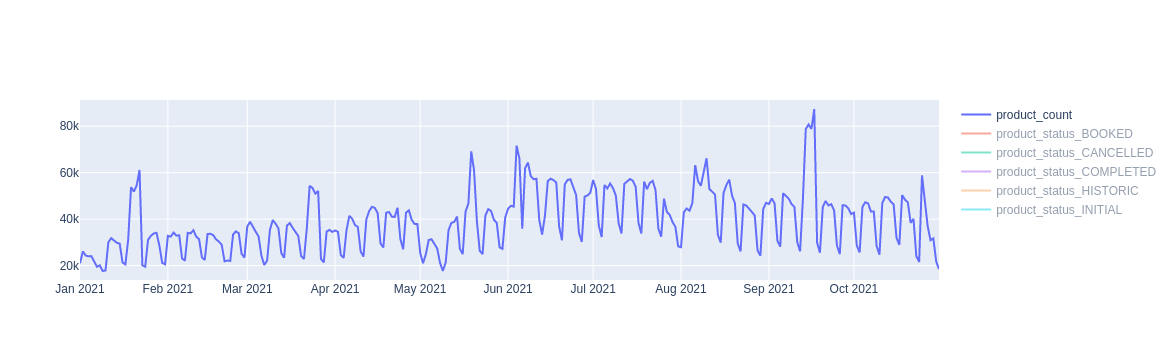

In [75]:
figure = go.Figure()
for col in df_pc.columns:
    figure.add_trace(go.Scatter(x=df_pc.index, y=df_pc[col], name=col))
figure

In [76]:
sales = pd.DataFrame({
  'holiday': 'sale',
  'ds': pd.to_datetime(['2021-09-14', '2020-06-23','2020-09-15', '2020-11-10', '2020-12-15','2021-01-19', '2021-03-23']),
  'lower_window': 0,
  'upper_window': 4,
})
import datetime
sale_dates=[]
for _, row in sales.iterrows():
    for shift in range(row.lower_window, row.upper_window+1):
        sale_dates.append(row.ds+datetime.timedelta(days=shift))

In [87]:
predictions = {}
for col in columns:
    print(col)
    
    log1past = pd.DataFrame(df_pc[col]).reset_index().rename(columns={col:'y','trx_day':'ds'})
    log1past['y'] = np.log(log1past.y)

    m = Prophet(
        weekly_seasonality = True,
        holidays=sales,
    #     daily_seasonality = True,
    #     yearly_seasonality = True,
        n_changepoints = 6,
        interval_width=0.99,
    #     mcmc_samples = 300,
        seasonality_mode='additive',
    )
    m.fit(log1past)
    forecast = m.predict(log1past)
    predictions[col] = np.exp(forecast.yhat.values)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_count


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_status_BOOKED


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_status_CANCELLED


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_status_COMPLETED


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_status_HISTORIC


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


product_status_INITIAL


In [88]:
pred_pc = pd.DataFrame(index=df_pc.index, data=predictions)

In [89]:
pred_pc

,product_count,product_status_BOOKED,product_status_CANCELLED,product_status_COMPLETED,product_status_HISTORIC,product_status_INITIAL
trx_day,,,,,,
2021-01-01,26816.977705,179.029979,3547.158100,20570.059666,2084.435968,200.778329
2021-01-02,19435.901282,111.448497,2627.832897,15147.161411,1283.691424,117.413069
2021-01-03,17343.394303,93.719589,2478.380051,13547.530363,1101.362377,85.815621
2021-01-04,27572.897400,185.728681,3646.764861,21150.214922,2052.500777,206.860701
2021-01-05,29083.554602,189.999163,3844.783899,22379.228210,2156.268240,222.829473
...,...,...,...,...,...,...
2021-10-27,42196.973812,560.964139,5435.726233,32204.758495,1432.045412,2551.631131
2021-10-28,40394.425731,555.339797,5323.908946,30815.783072,1294.244851,2247.060599
2021-10-29,39307.934910,548.755620,5018.254143,30015.916073,1348.243092,2307.101211


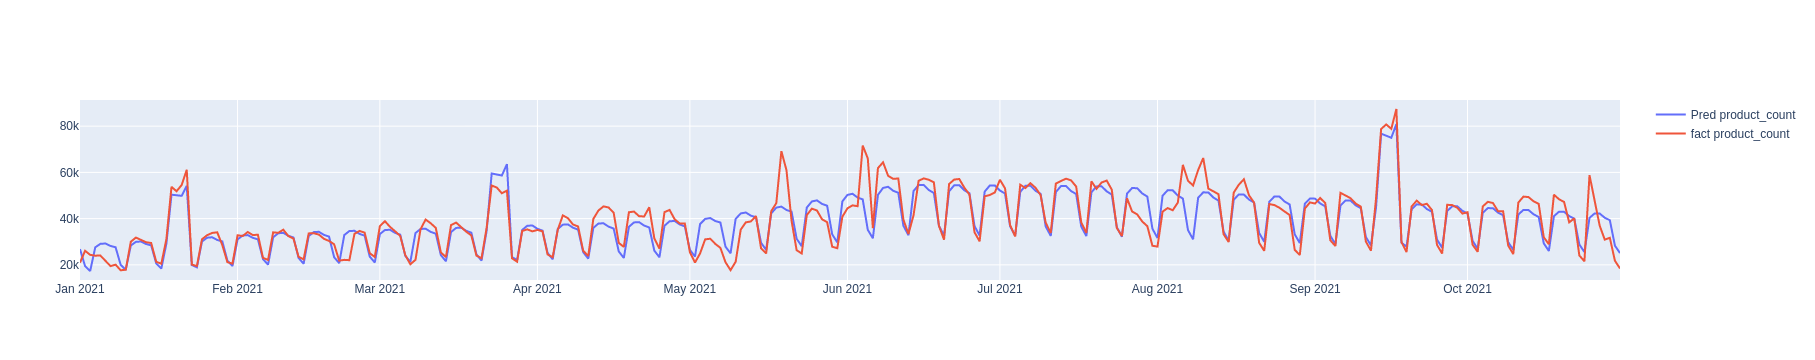

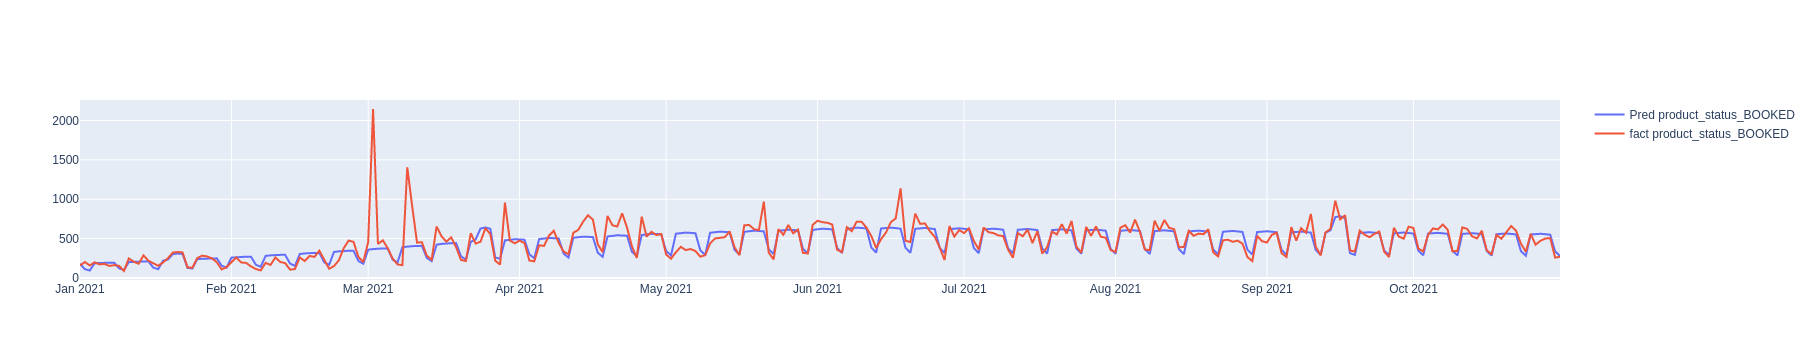

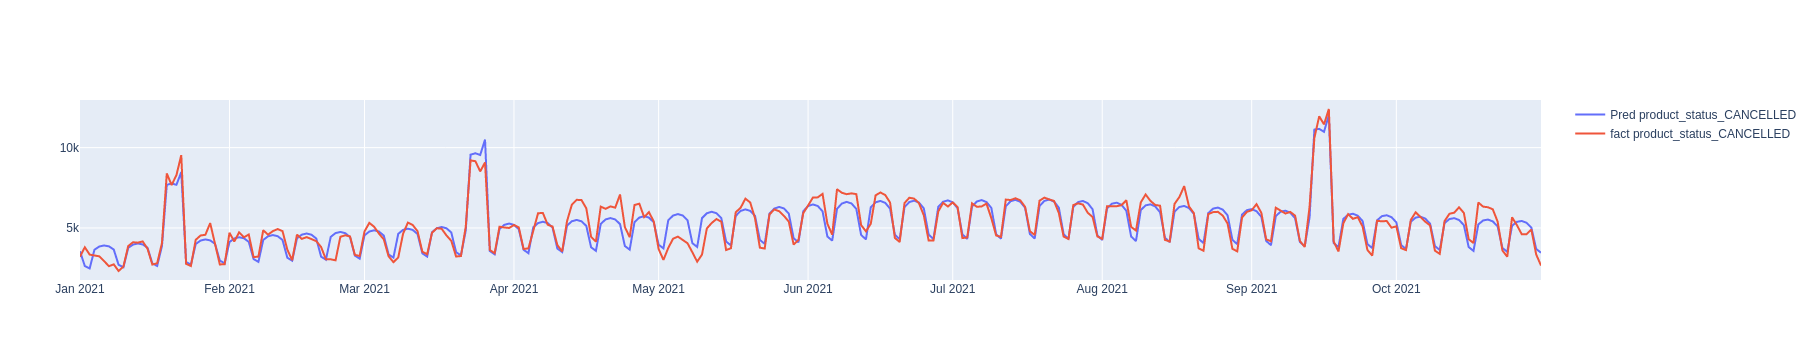

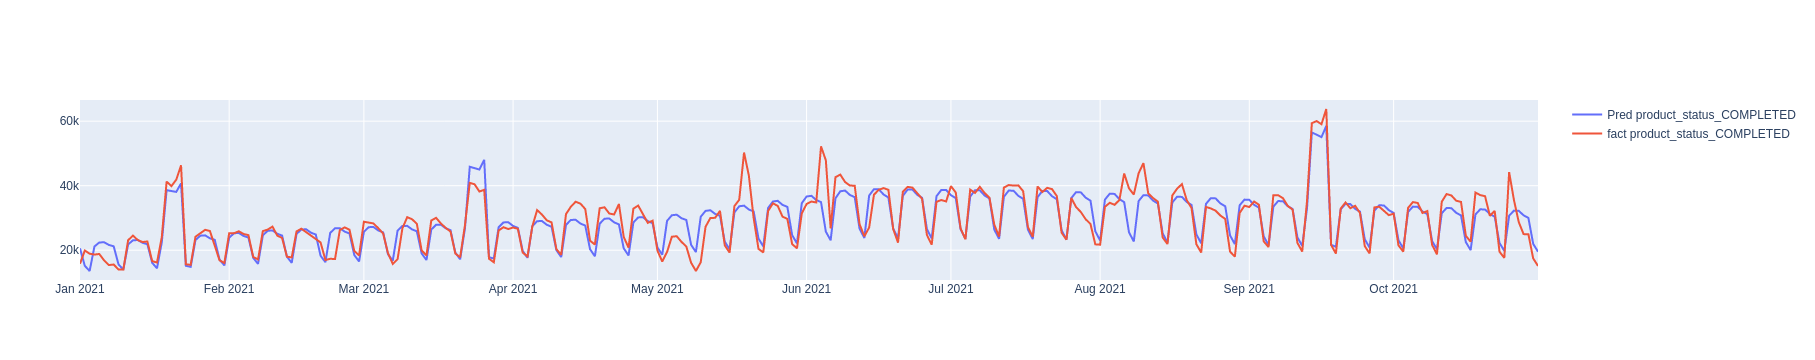

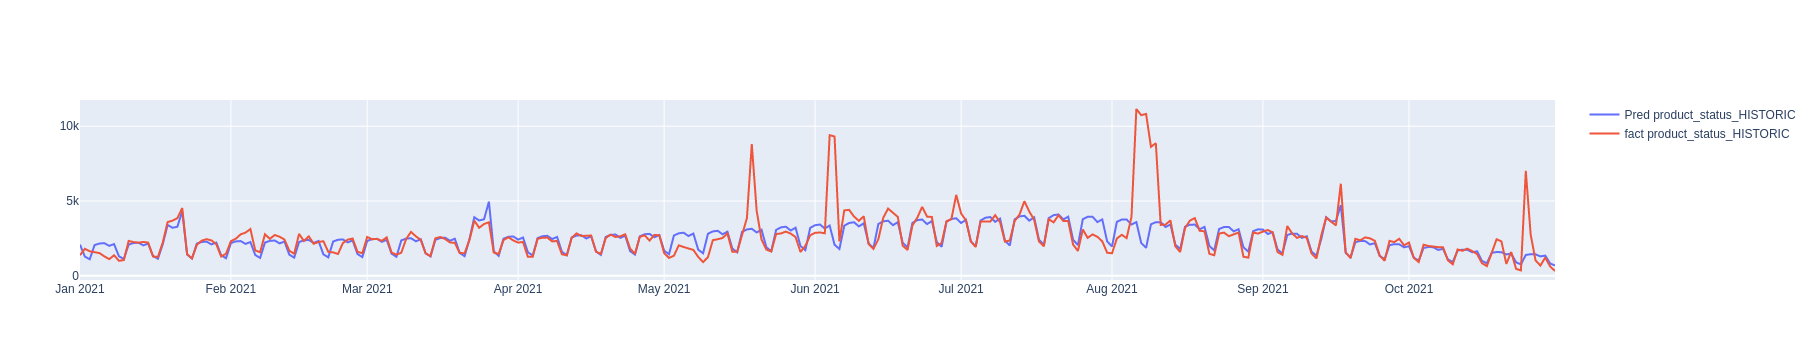

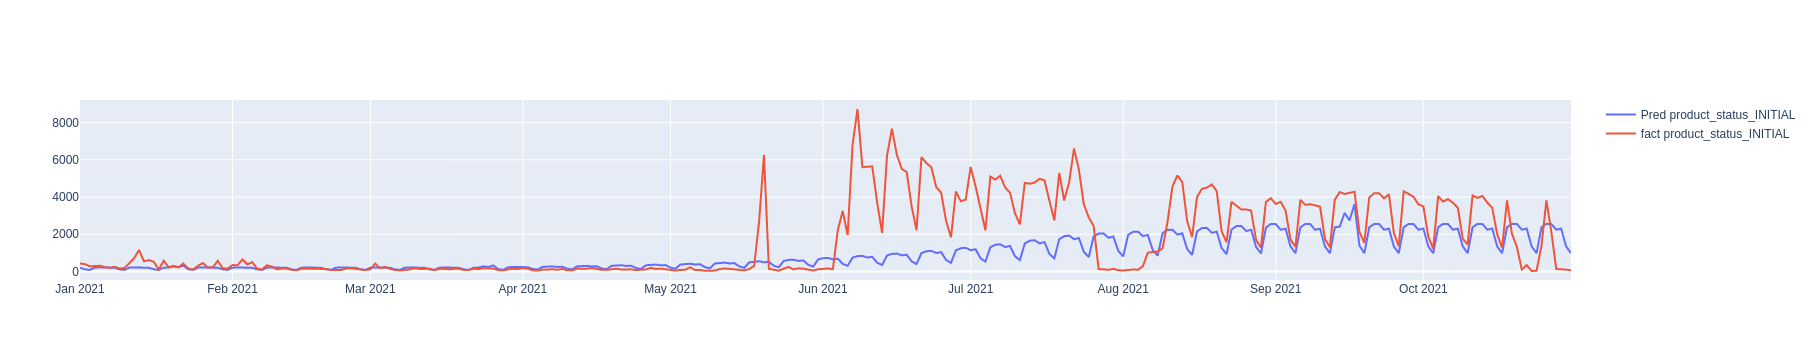

In [91]:
for col in columns:
    figure = go.Figure()
    y_pred = np.exp(forecast.yhat)
    figure.add_trace(go.Scatter(x=pred_pc.index, y=pred_pc[col], name=f'Pred {col}'))
    figure.add_trace(go.Scatter(x=df_pc.index, y=df_pc[col], name=f'fact {col}'))
    figure.show()

In [114]:
loglikelihoods = {}
for col in columns:
    delta = df_pc[col] - pred_pc[col]
    mean, std = delta.mean(), delta.std()
    loglikelihood = np.log(norm.pdf(delta, loc=mean, scale=std))
    loglikelihoods[col] = loglikelihood

In [115]:
loglikelihoods = pd.DataFrame(index=df_pc.index, data=loglikelihoods)

In [116]:
loglikelihoods

,product_count,product_status_BOOKED,product_status_CANCELLED,product_status_COMPLETED,product_status_HISTORIC,product_status_INITIAL
trx_day,,,,,,
2021-01-01,-10.178584,-5.978289,-7.465760,-10.015476,-8.286923,-8.355251
2021-01-02,-10.155601,-6.065790,-9.339319,-9.831218,-8.093531,-8.344552
2021-01-03,-10.216904,-5.996709,-8.353798,-10.014070,-8.098168,-8.363419
2021-01-04,-9.830887,-5.947178,-7.520582,-9.462506,-8.174710,-8.388892
2021-01-05,-10.032210,-5.972031,-7.916300,-9.675525,-8.250964,-8.388621
...,...,...,...,...,...,...
2021-10-27,-10.064511,-6.184136,-8.428739,-9.658946,-8.148612,-8.569206
2021-10-28,-11.048790,-6.053645,-8.133157,-10.378332,-8.237531,-9.902330
2021-10-29,-10.547650,-6.024024,-7.275571,-10.103017,-8.075396,-9.982545


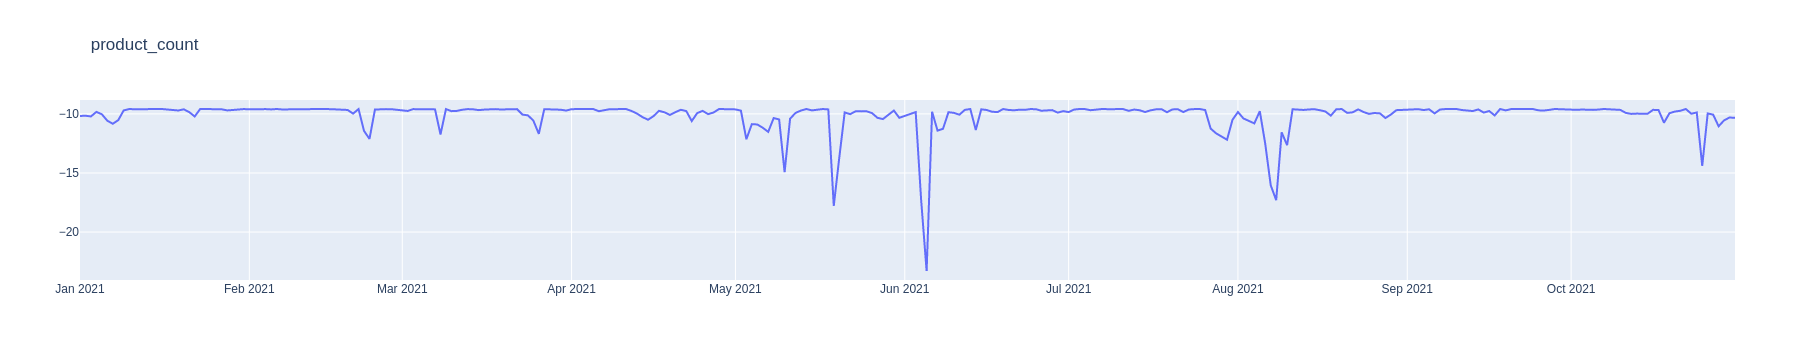

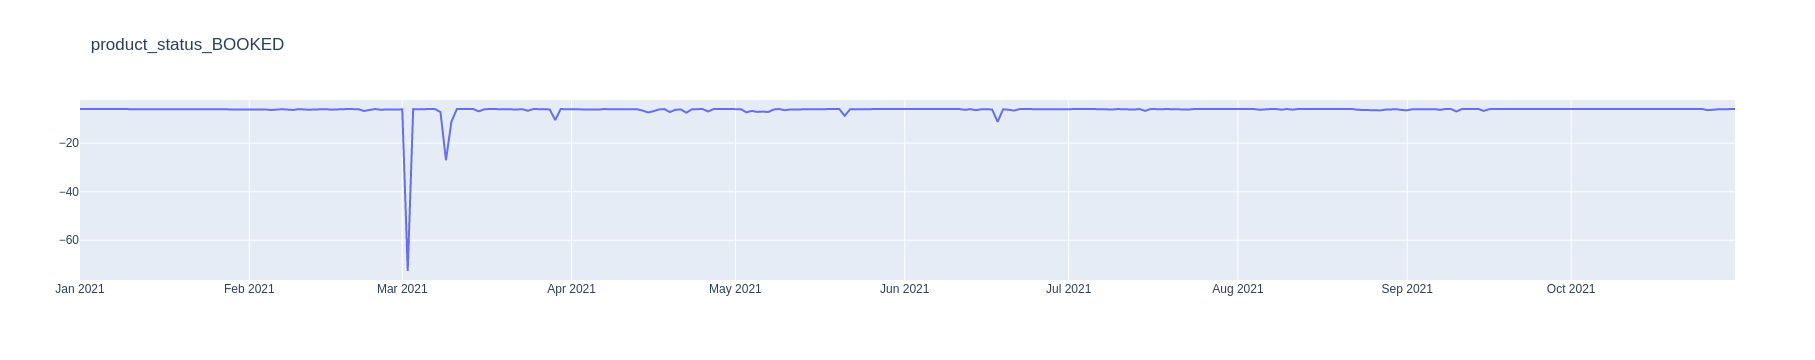

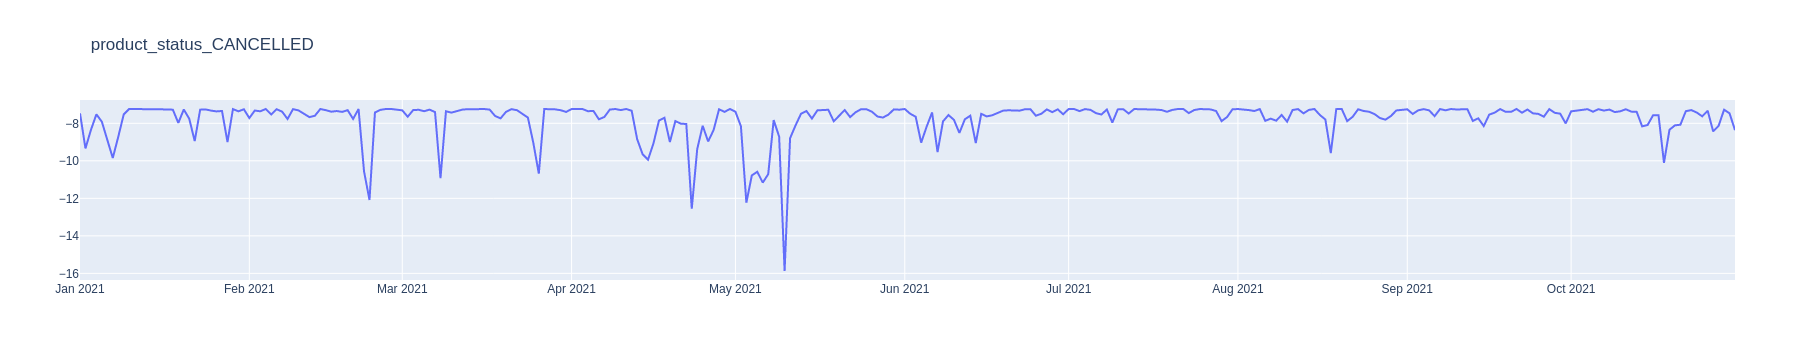

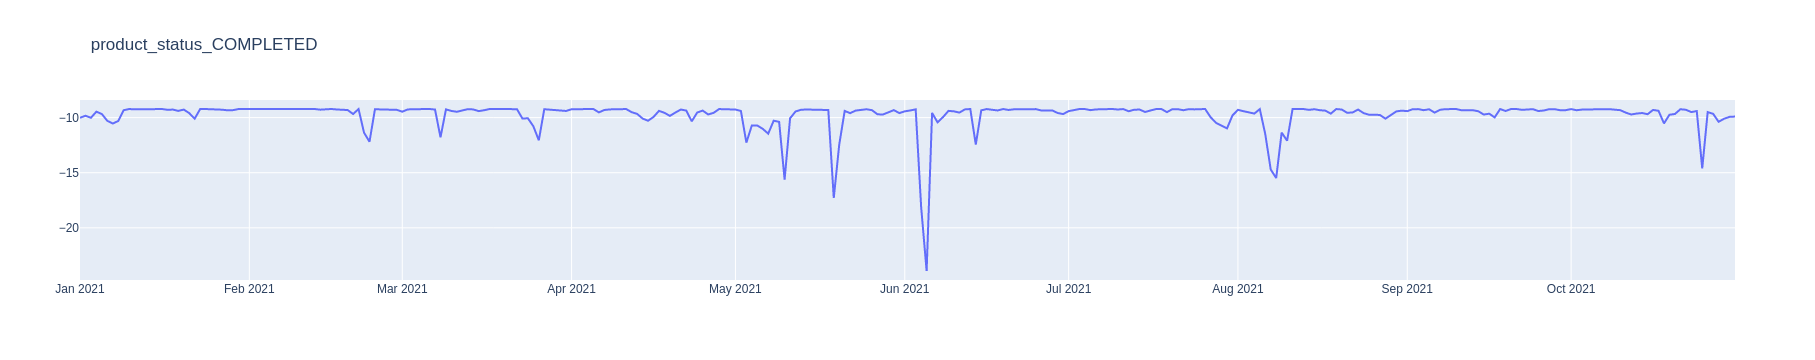

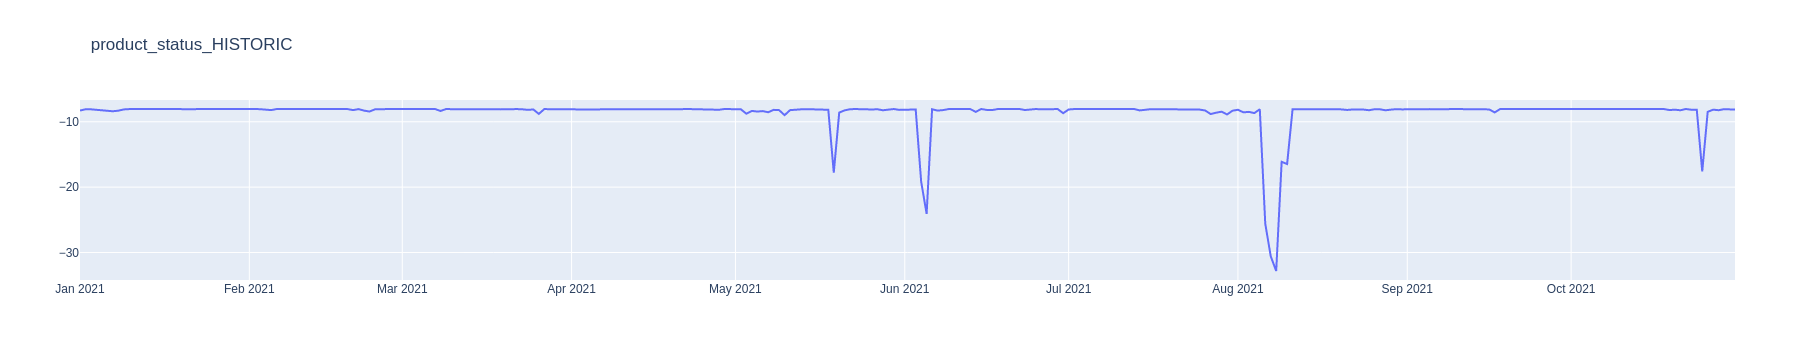

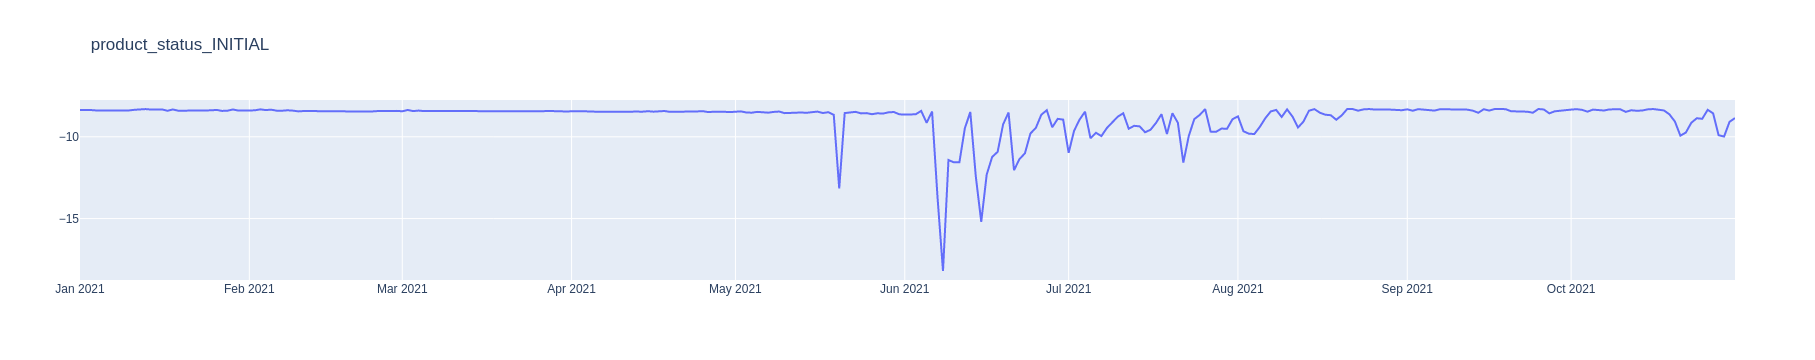

In [118]:
for col in columns:
    figure = go.Figure(layout={'title':col})
    figure.add_trace(go.Scatter(x=pred_pc.index, y=loglikelihoods[col], name=f'Loglikelihood {col}'))
    figure.show()

In [121]:
used_columns = [c for c in columns if c !='product_status_INITIAL']

In [124]:
ll = loglikelihoods[used_columns].sum(axis='columns')

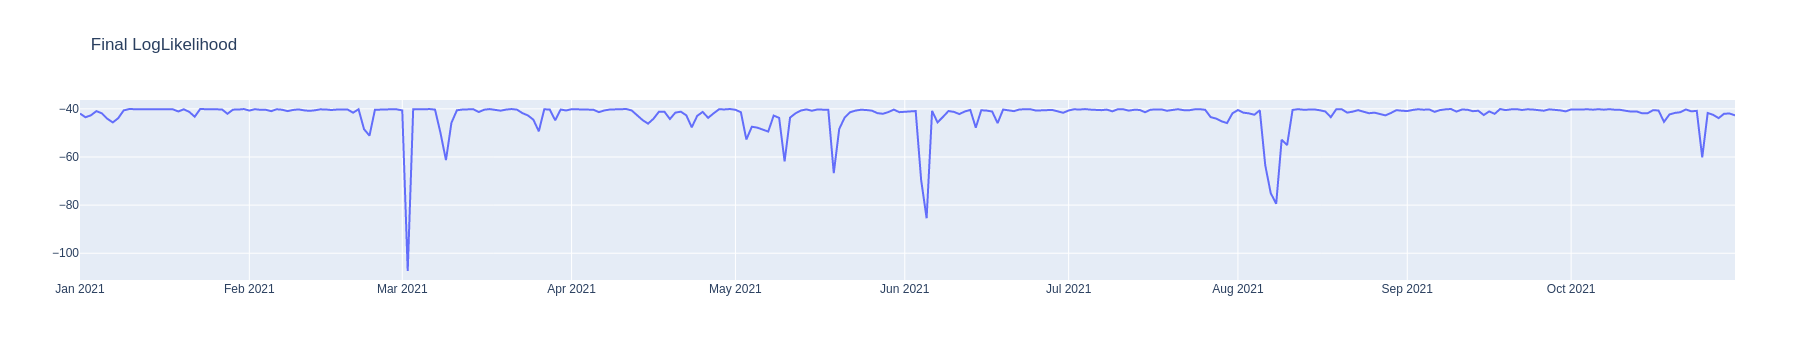

In [126]:
figure = go.Figure(layout={'title':'Final LogLikelihood'})
figure.add_trace(go.Scatter(x=ll.index, y=ll, name=f'Loglikelihood'))
figure.show()